In [1]:
# General
import warnings
warnings.filterwarnings("ignore")

# Create circuit to test transpiler on
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import GroverOperator, Diagonal

# Use Statevector object to calculate the ideal output
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram

# Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService, Batch, Sampler

In [2]:
from qiskit.providers.fake_provider import FakeCairoV2
backend = FakeCairoV2()
print(backend.target)

Target
Number of qubits: 27
Instructions:
	id
		(0,):
			Duration: 2.1333333333333332e-08 sec.
			Error Rate: 0.0001861160620504811
			With pulse schedule calibration
		(1,):
			Duration: 2.1333333333333332e-08 sec.
			Error Rate: 0.0002130147960804518
			With pulse schedule calibration
		(2,):
			Duration: 2.1333333333333332e-08 sec.
			Error Rate: 0.0002439000316463972
			With pulse schedule calibration
		(3,):
			Duration: 2.1333333333333332e-08 sec.
			Error Rate: 0.0002674001201093346
			With pulse schedule calibration
		(4,):
			Duration: 2.1333333333333332e-08 sec.
			Error Rate: 0.00036308489456102395
			With pulse schedule calibration
		(5,):
			Duration: 2.1333333333333332e-08 sec.
			Error Rate: 0.00029411586236621827
			With pulse schedule calibration
		(6,):
			Duration: 2.1333333333333332e-08 sec.
			Error Rate: 0.0004814259500114862
			With pulse schedule calibration
		(7,):
			Duration: 2.1333333333333332e-08 sec.
			Error Rate: 0.000838355811378628
			With pulse schedu

In [3]:
# oracle = Diagonal([1] * 7 + [-1])
# qc = QuantumCircuit(3)
# qc.h([0, 1, 2])
# qc = qc.compose(GroverOperator(oracle))

# qc.draw(output="mpl", style="iqp")


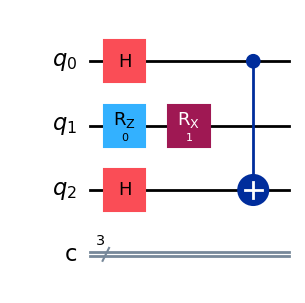

In [3]:
from qiskit import QuantumCircuit, BasicAer, execute
from qiskit.visualization import plot_histogram

qc = QuantumCircuit(3, 3)
qc.rz(0,1)
qc.rx(1,1)
qc.h([0,2])
qc.cx(0, 2)


display(qc.draw("mpl", style="iqp"))

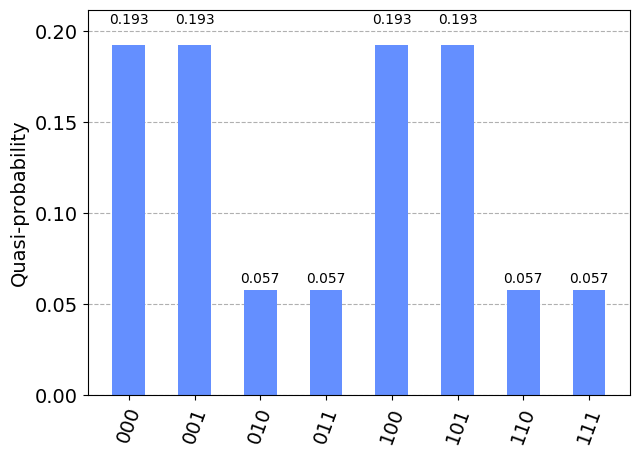

In [4]:
ideal_distribution = Statevector.from_instruction(qc).probabilities_dict()

plot_histogram(ideal_distribution)

In [5]:
print(qc.count_ops())


OrderedDict([('h', 2), ('rz', 1), ('rx', 1), ('cx', 1)])


In [6]:
# Need to add measurements to the circuit
qc.measure_all()

circuits = []
for optimization_level in [0, 3]:
    t_qc = transpile(qc, backend, optimization_level=optimization_level, seed_transpiler=0)
    print(f"CNOTs (optimization_level={optimization_level}): ", t_qc.count_ops()["rz"])
    circuits.append(t_qc)

CNOTs (optimization_level=0):  8
CNOTs (optimization_level=3):  7


In [7]:
from qiskit.transpiler import PassManager
from qiskit_ibm_runtime.transpiler.passes.scheduling import (
    ASAPScheduleAnalysis,
    PadDynamicalDecoupling,
)
from qiskit.circuit.library import XGate

# Get gate durations so the transpiler knows how long each operation takes
durations = backend.target.durations()

# This is the sequence we'll apply to idling qubits
dd_sequence = [XGate(), XGate()]

# Run scheduling and dynamic decoupling passes on circuit
pm = PassManager([ASAPScheduleAnalysis(durations), PadDynamicalDecoupling(durations, dd_sequence)])
circ_dd = pm.run(circuits[1])

# Add this new circuit to our list
circuits.append(circ_dd)

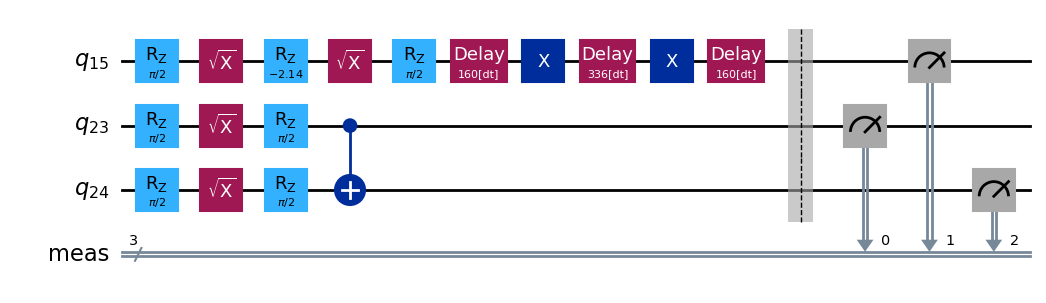

In [8]:
circ_dd.draw(output="mpl", style="iqp", idle_wires=False)

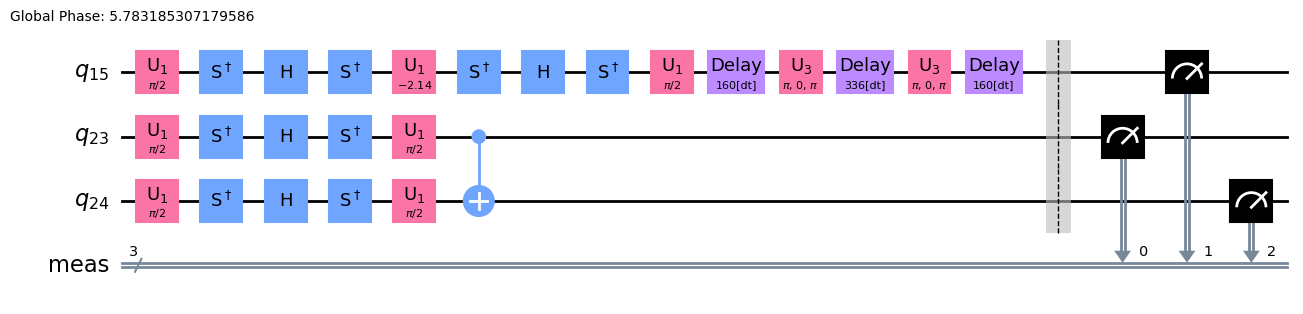

In [10]:
circ_dd.decompose().draw(output="mpl",idle_wires=False)

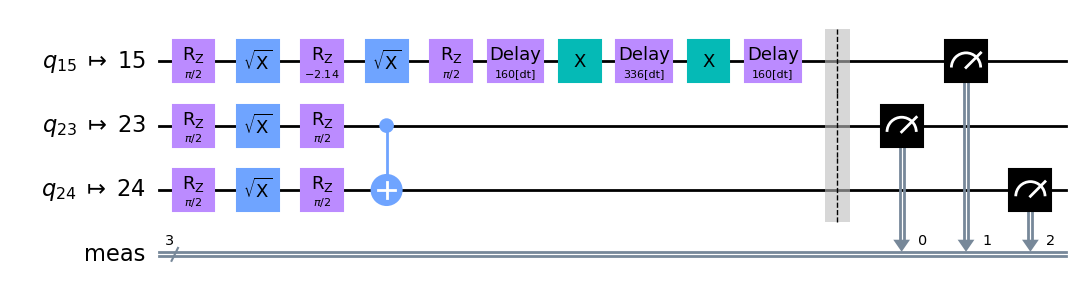

In [11]:
from qiskit import transpile
circ_dd_basis = transpile(circ_dd, backend)
circ_dd_basis.draw(output='mpl',idle_wires=False)

In [29]:
job_simulator_noisy = execute(circ_dd,backend,shots=8000,skip_transpilation=True)
counts_simulator_noisy = job_simulator_noisy.result()
counts_simulator_noisy 

Result(backend_name='aer_simulator', backend_version='0.13.1', qobj_id='', job_id='49bc0941-8ce5-4b19-9874-e1bae445ba94', success=True, results=[ExperimentResult(shots=8000, success=True, meas_level=2, data=ExperimentResultData(counts={'0x20': 1511, '0x8': 1551, '0x28': 1564, '0x0': 1553, '0x30': 468, '0x38': 431, '0x18': 443, '0x10': 479}), header=QobjExperimentHeader(creg_sizes=[['c', 3], ['meas', 3]], global_phase=0.0, memory_slots=6, n_qubits=27, name='circuit-158', qreg_sizes=[['q', 27]], metadata={}), status=DONE, seed_simulator=2555455891, metadata={'batched_shots_optimization': False, 'required_memory_mb': 1, 'method': 'density_matrix', 'active_input_qubits': [15, 23, 24], 'device': 'CPU', 'remapped_qubits': True, 'num_qubits': 3, 'num_clbits': 6, 'time_taken': 0.0358585, 'sample_measure_time': 0.0054155, 'input_qubit_map': [[23, 1], [15, 0], [24, 2]], 'max_memory_mb': 8112, 'measure_sampling': True, 'noise': 'superop', 'parallel_shots': 1, 'parallel_state_update': 8, 'runtime_

In [36]:
counts_simulator_noisy = job_simulator_noisy.result().get_counts()

counts_simulator_noisy


{'100 000': 1511,
 '001 000': 1551,
 '101 000': 1564,
 '000 000': 1553,
 '110 000': 468,
 '111 000': 431,
 '011 000': 443,
 '010 000': 479}

In [37]:
from qiskit.quantum_info import hellinger_fidelity
binary_prob = [quasi_dist.binary_probabilities() for quasi_dist in counts_simulator_noisy.quasi_dists]
plot_histogram(
    binary_prob + [ideal_distribution],
    bar_labels=False,
    legend=[
        "optimization_level=0",
        "optimization_level=3",
        "optimization_level=3 + dd",
        "ideal distribution",
    ],
)

AttributeError: 'Counts' object has no attribute 'quasi_dists'

In [12]:
from qiskit.quantum_info import hellinger_fidelity

for counts in result.quasi_dists:
    print(f"{hellinger_fidelity(counts.binary_probabilities(), ideal_distribution):.3f}")

0.000
0.000
0.000
